# Проект: Дашборд конверсий

In [ ]:
# Импорт библиотек
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dotenv import load_dotenv
from io import StringIO

In [ ]:
# Загрузка переменных окружения
load_dotenv()

False

In [ ]:
# Конфигурация
API_URL = os.getenv('API_URL', 'https://data-charts-api.hexlet.app')
DATE_BEGIN = os.getenv('DATE_BEGIN', '2023-03-01')
DATE_END = os.getenv('DATE_END', '2023-09-01')

print(f"API_URL: {API_URL}")
print(f"Период анализа: {DATE_BEGIN} - {DATE_END}")

API_URL: https://data-charts-api.hexlet.app
Период анализа: 2023-03-01 - 2023-09-01


In [ ]:
# Создание директорий
os.makedirs('./charts', exist_ok=True)

In [ ]:
# Загрузка данных регистраций
reg_response = requests.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})
df_registrations = pd.DataFrame(reg_response.json())
print(f"Загружено регистраций: {len(df_registrations)}")

Загружено регистраций: 21836


In [ ]:
# Загрузка данных посещений
visits_response = requests.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})
df_visits = pd.DataFrame(visits_response.json())
print(f"Загружено посещений: {len(df_visits)}")

Загружено посещений: 263459


In [ ]:
# Загрузка рекламных данных
url = "https://drive.google.com/file/d/12vCtGhJlcK_CBcs8ES3BfEPbk6OJ45Qj/view"
file_id = url.split('/')[-2]
download_url = f"https://drive.google.com/uc?export=download&id={file_id}"
response = requests.get(download_url)
df_ads = pd.read_csv(StringIO(response.text))

#  2. Предобработка данных

In [ ]:
# Преобразование дат
df_visits['datetime'] = pd.to_datetime(df_visits['datetime'])
df_registrations['datetime'] = pd.to_datetime(df_registrations['datetime'])
df_ads['date'] = pd.to_datetime(df_ads['date'])

In [ ]:
# Создание колонок с датой
df_visits['date_group'] = df_visits['datetime'].dt.date
df_registrations['date_group'] = df_registrations['datetime'].dt.date
df_ads['date_group'] = df_ads['date'].dt.date

In [ ]:
# Фильтрация ботов и последние визиты
df_visits_clean = df_visits[df_visits['platform'] != 'bot'].copy()
df_visits_last = df_visits_clean.sort_values('datetime').groupby('visit_id').last().reset_index()

print(f"Уникальных визитов после обработки: {len(df_visits_last)}")

Уникальных визитов после обработки: 138703


#  3. Расчет конверсии

In [ ]:
# Группировка визитов и регистраций
visits_grouped = df_visits_last.groupby(['date_group', 'platform']).size().reset_index(name='visits')
registrations_grouped = df_registrations.groupby(['date_group', 'platform']).size().reset_index(name='registrations')

In [ ]:
# Объединение и расчет конверсии
df_conversion = pd.merge(visits_grouped, registrations_grouped, on=['date_group', 'platform'], how='outer')
df_conversion['visits'] = df_conversion['visits'].fillna(0)
df_conversion['registrations'] = df_conversion['registrations'].fillna(0)
df_conversion['conversion'] = (df_conversion['registrations'] / df_conversion['visits'] * 100).round(6)
df_conversion = df_conversion.sort_values('date_group')

print("Датафрейм конверсии создан")
print(f"Размер: {df_conversion.shape}")

Датафрейм конверсии создан
Размер: (552, 5)


#  4. Объединение с рекламными данными

In [ ]:
# Группировка рекламных данных
ads_grouped = df_ads.groupby('date_group').agg({
    'cost': 'sum',
    'utm_campaign': lambda x: ', '.join(x.unique()) if len(x.unique()) > 0 else 'none'
}).reset_index()


In [ ]:
# Создание базового датафрейма с датами
date_range = pd.date_range(start=DATE_BEGIN, end=DATE_END, freq='D')
base_df = pd.DataFrame({'date_group': date_range.date})

In [ ]:
# Агрегация конверсий по датам
conversion_by_date = df_conversion.groupby('date_group').agg({
    'visits': 'sum',
    'registrations': 'sum'
}).reset_index()

In [ ]:
# Объединение всех данных
df_final = pd.merge(base_df, conversion_by_date, on='date_group', how='left')
df_final = pd.merge(df_final, ads_grouped, on='date_group', how='left')

In [ ]:
# Заполнение пропусков
df_final['visits'] = df_final['visits'].fillna(0).astype(int)
df_final['registrations'] = df_final['registrations'].fillna(0).astype(int)
df_final['cost'] = df_final['cost'].fillna(0)
df_final['utm_campaign'] = df_final['utm_campaign'].fillna('none')
df_final = df_final.sort_values('date_group')

print("Итоговый датафрейм создан")
print(f"Размер: {df_final.shape}")

Итоговый датафрейм создан
Размер: (185, 5)


#  5. Сохранение результатов

In [ ]:
# Сохранение в JSON
df_conversion.to_json('conversion.json', orient='columns', indent=2)
df_final.to_json('ads.json', orient='columns', indent=2)
print("Файлы conversion.json и ads.json сохранены")

Файлы conversion.json и ads.json сохранены


#  6. Визуализация

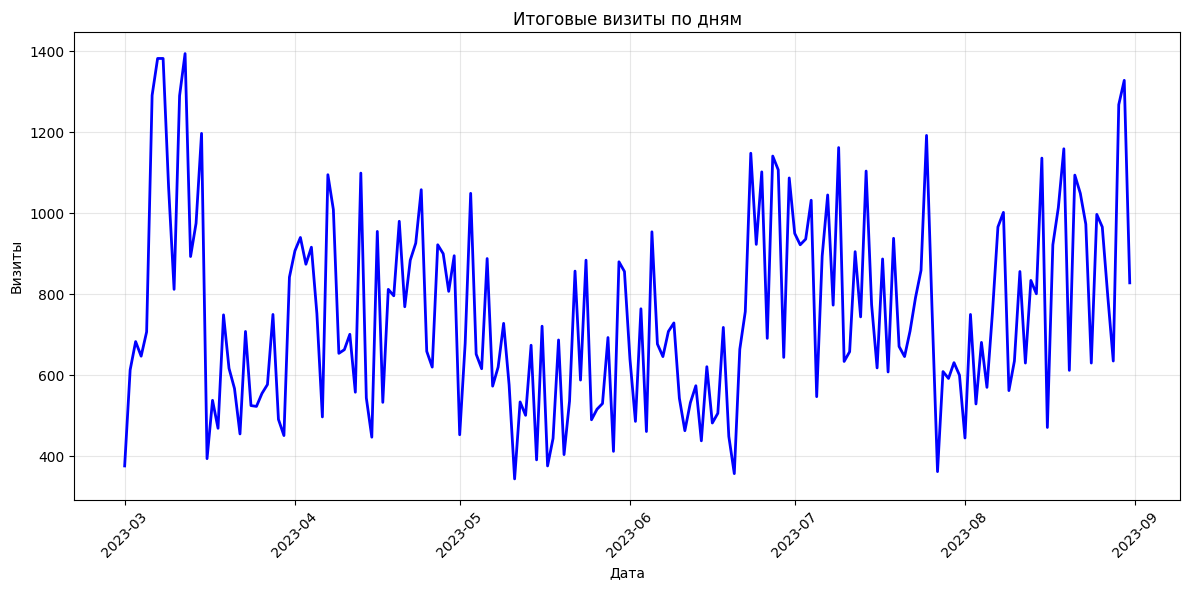

In [ ]:
# 1. Итоговые визиты
plt.figure(figsize=(12, 6))
total_visits = df_conversion.groupby('date_group')['visits'].sum()
plt.plot(total_visits.index, total_visits.values, linewidth=2, color='blue')
plt.title('Итоговые визиты по дням')
plt.xlabel('Дата'); plt.ylabel('Визиты'); plt.grid(True, alpha=0.3); plt.xticks(rotation=45)
plt.tight_layout(); plt.savefig('./charts/total_visits.png', dpi=300, bbox_inches='tight'); plt.show()

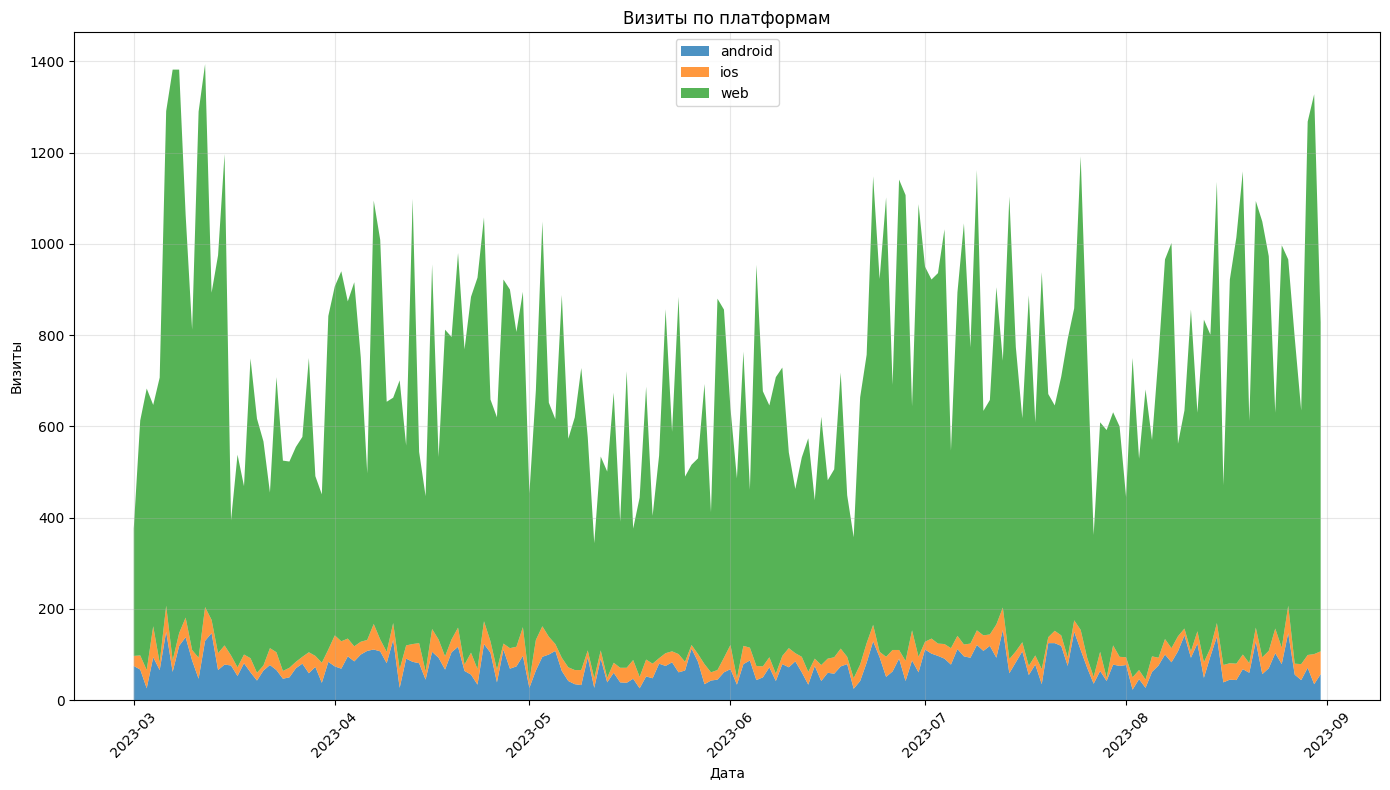

In [ ]:
# 2. Визиты по платформам
plt.figure(figsize=(14, 8))

visits_by_platform = df_conversion.pivot_table(
    index='date_group',
    columns='platform',
    values='visits',
    aggfunc='sum'
).fillna(0)

# Получаем список платформ из столбцов pivot таблицы
platforms = visits_by_platform.columns.tolist()

plt.stackplot(
    visits_by_platform.index,
    [visits_by_platform[p] for p in platforms],
    labels=platforms,
    alpha=0.8
)

plt.title('Визиты по платформам')
plt.xlabel('Дата')
plt.ylabel('Визиты')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./charts/visits_by_platform.png', dpi=300, bbox_inches='tight')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

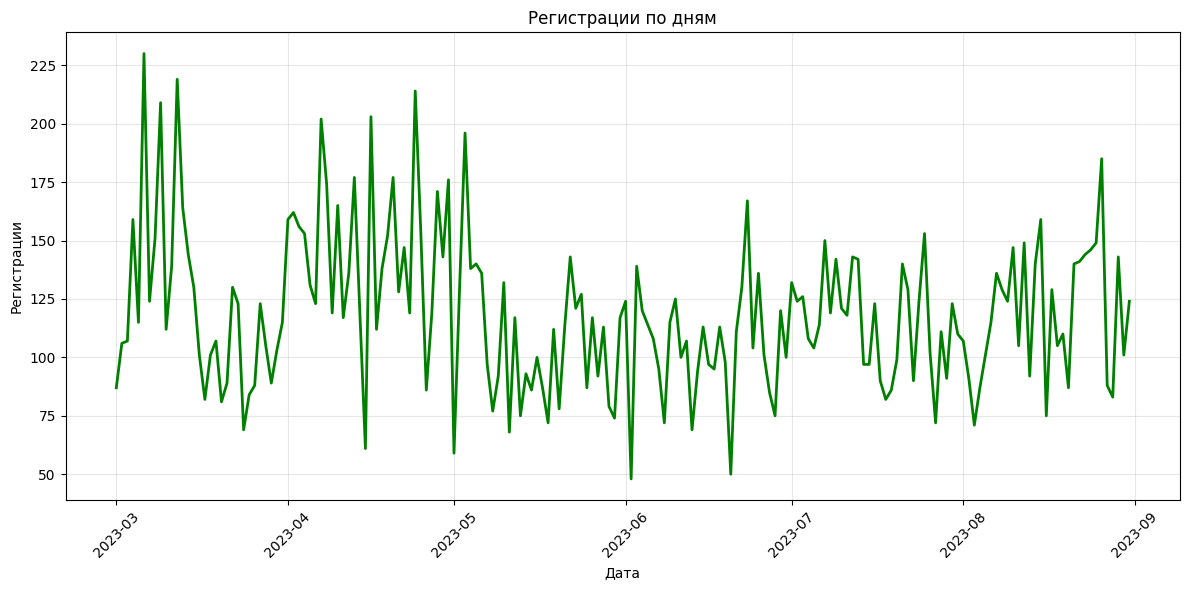

In [ ]:
# 3. Итоговые регистрации
plt.figure(figsize=(12, 6))
total_regs = df_conversion.groupby('date_group')['registrations'].sum()
plt.plot(total_regs.index, total_regs.values, linewidth=2, color='green')
plt.title('Регистрации по дням'); plt.xlabel('Дата'); plt.ylabel('Регистрации'); plt.grid(True, alpha=0.3)
plt.xticks(rotation=45); plt.tight_layout(); plt.savefig('./charts/total_registrations.png', dpi=300, bbox_inches='tight'); plt.show

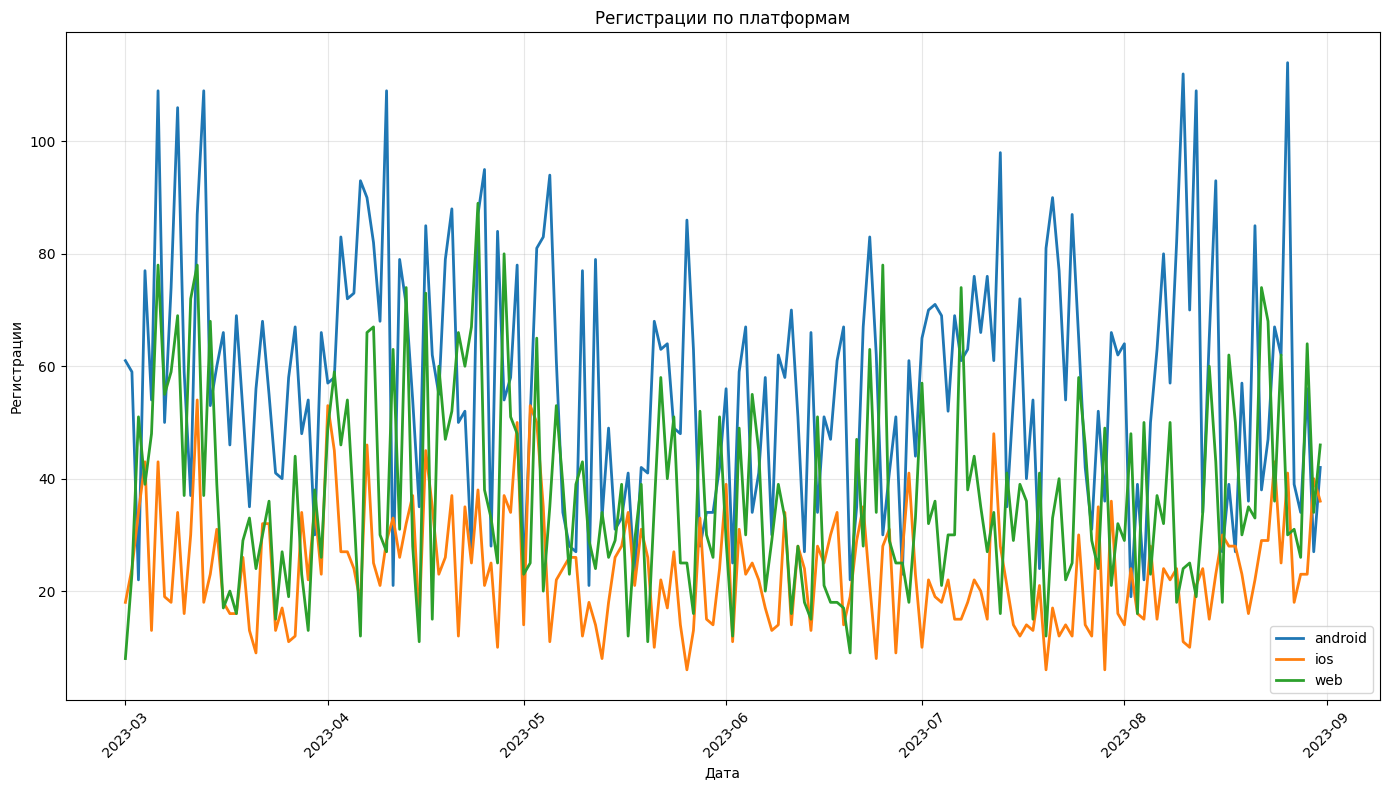

In [ ]:
# 4. Регистрации по платформам
plt.figure(figsize=(14, 8))
regs_by_platform = df_conversion.pivot_table(index='date_group', columns='platform', values='registrations', aggfunc='sum').fillna(0)
for platform in platforms:
    plt.plot(regs_by_platform.index, regs_by_platform[platform], label=platform, linewidth=2)
plt.title('Регистрации по платформам'); plt.xlabel('Дата'); plt.ylabel('Регистрации'); plt.legend(); plt.grid(True, alpha=0.3)
plt.xticks(rotation=45); plt.tight_layout(); plt.savefig('./charts/registrations_by_platform.png', dpi=300, bbox_inches='tight'); plt.show()

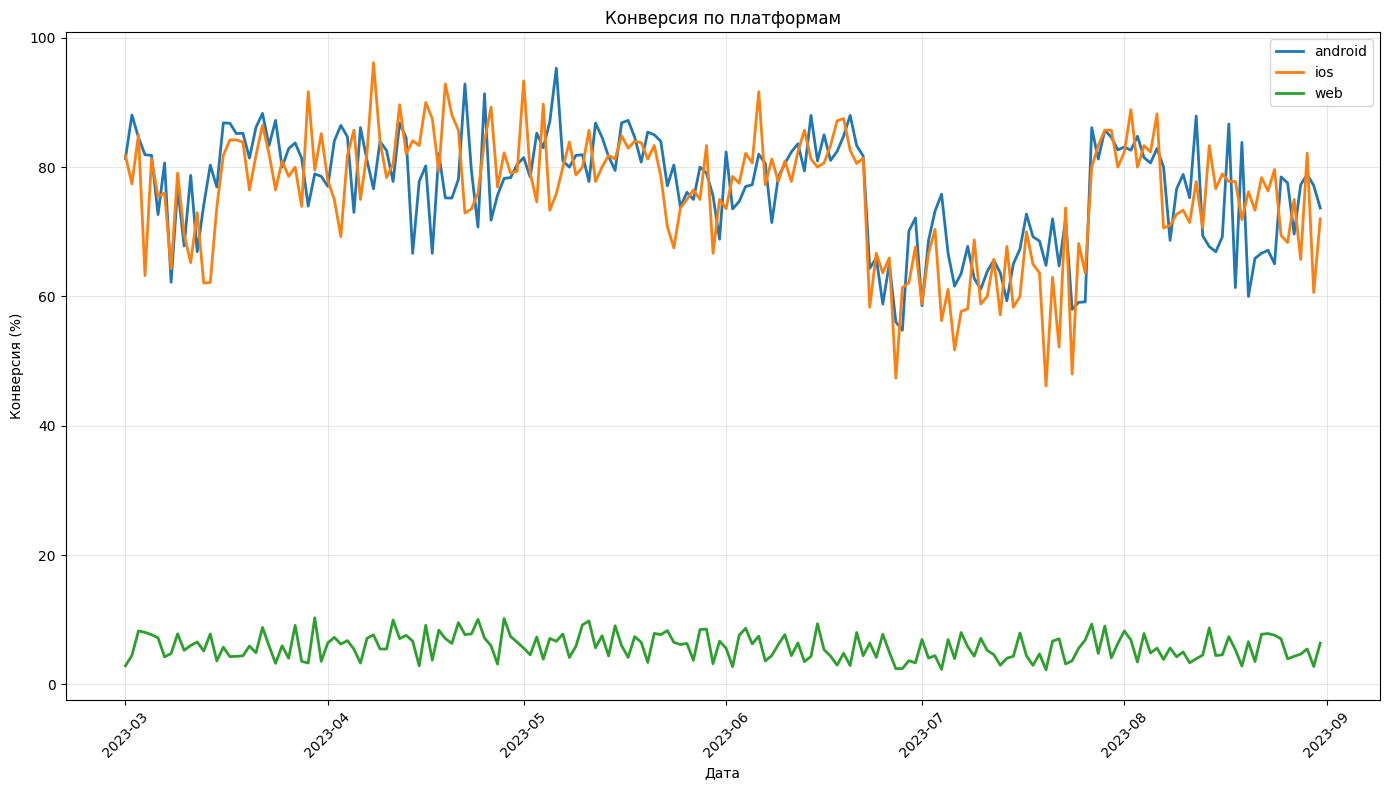

In [ ]:
# 5. Конверсия по платформам
plt.figure(figsize=(14, 8))
for platform in platforms:
    platform_data = df_conversion[df_conversion['platform'] == platform]
    plt.plot(platform_data['date_group'], platform_data['conversion'], label=platform, linewidth=2)
plt.title('Конверсия по платформам'); plt.xlabel('Дата'); plt.ylabel('Конверсия (%)'); plt.legend(); plt.grid(True, alpha=0.3)
plt.xticks(rotation=45); plt.tight_layout(); plt.savefig('./charts/conversion_by_platform.png', dpi=300, bbox_inches='tight'); plt.show()

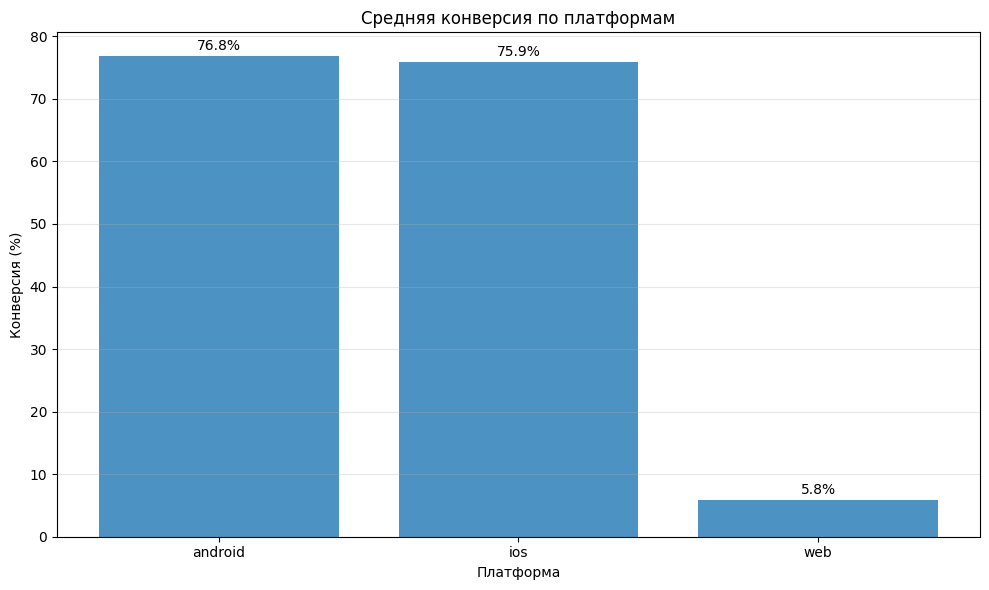

In [ ]:
# 6. Средняя конверсия
plt.figure(figsize=(10, 6))
avg_conv = df_conversion.groupby('platform')['conversion'].mean()
bars = plt.bar(avg_conv.index, avg_conv.values, alpha=0.8)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5, f'{bar.get_height():.1f}%', ha='center', va='bottom')
plt.title('Средняя конверсия по платформам'); plt.xlabel('Платформа'); plt.ylabel('Конверсия (%)'); plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout(); plt.savefig('./charts/average_conversion.png', dpi=300, bbox_inches='tight'); plt.show()

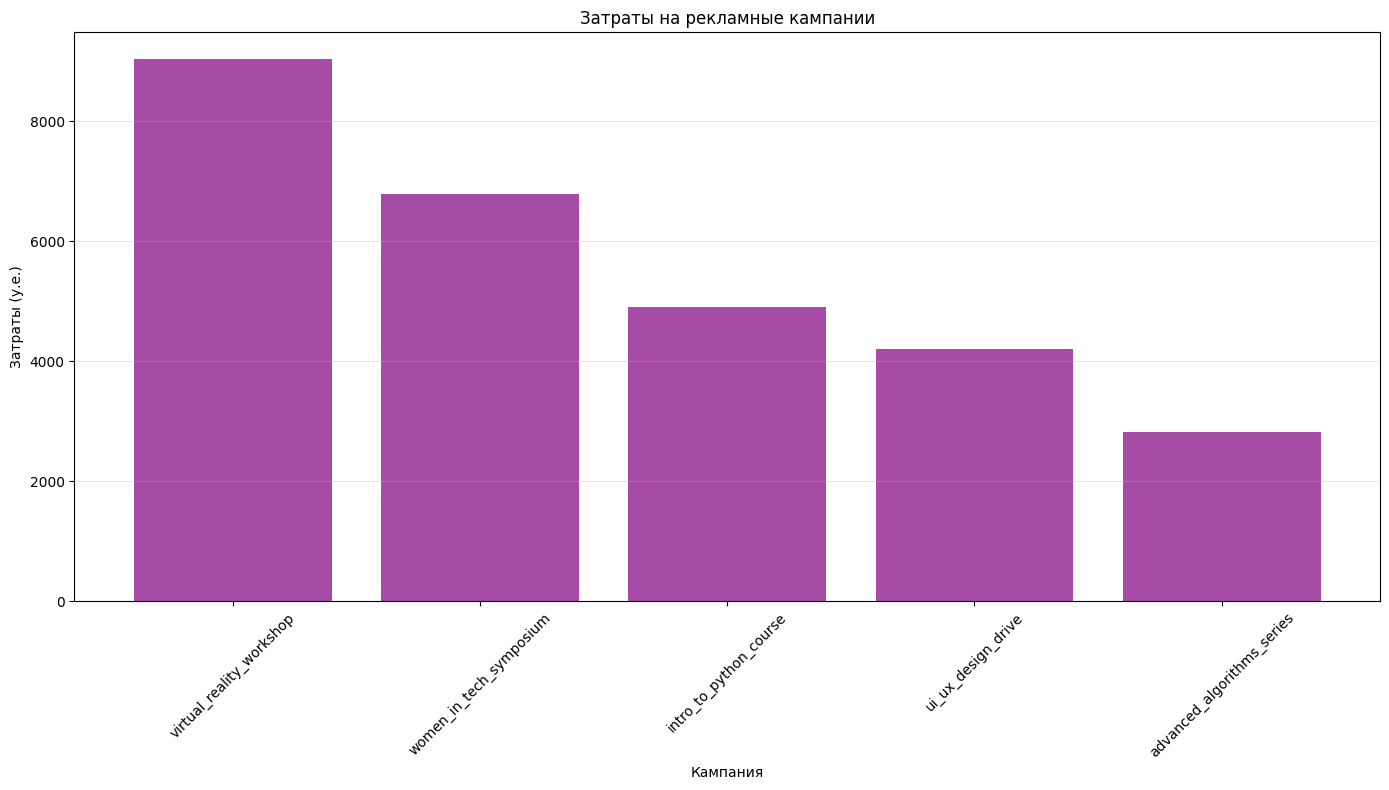

In [ ]:
# 7. Затраты на рекламу
plt.figure(figsize=(14, 8))
ads_data = df_final[df_final['cost'] > 0]
if len(ads_data) > 0:
    campaign_costs = ads_data.groupby('utm_campaign')['cost'].sum().sort_values(ascending=False)
    plt.bar(campaign_costs.index, campaign_costs.values, color='purple', alpha=0.7)
    plt.title('Затраты на рекламные кампании'); plt.xlabel('Кампания'); plt.ylabel('Затраты (у.е.)'); plt.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45); plt.tight_layout(); plt.savefig('./charts/advertising_costs.png', dpi=300, bbox_inches='tight'); plt.show()

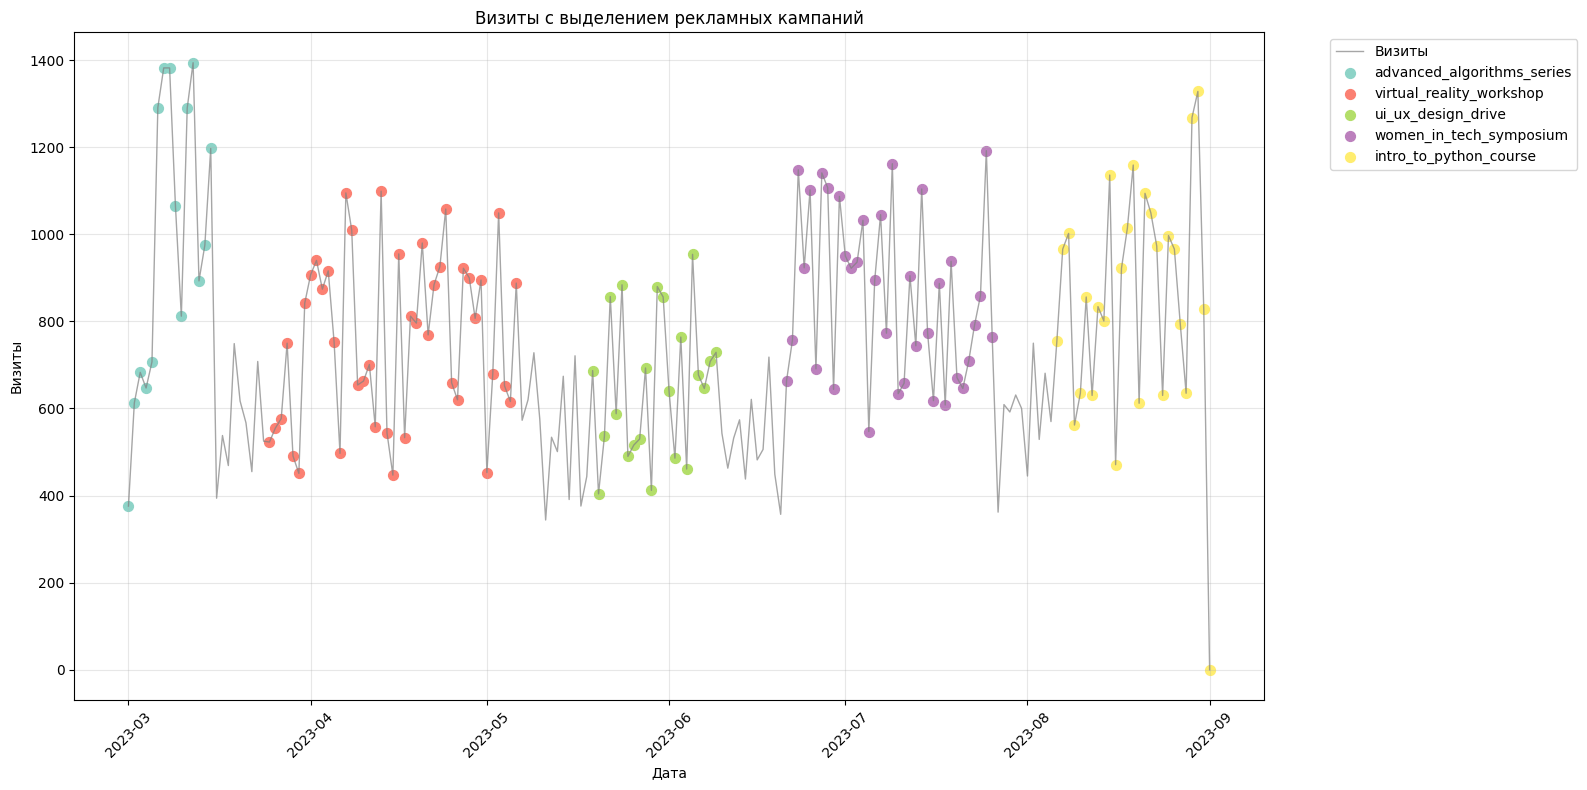

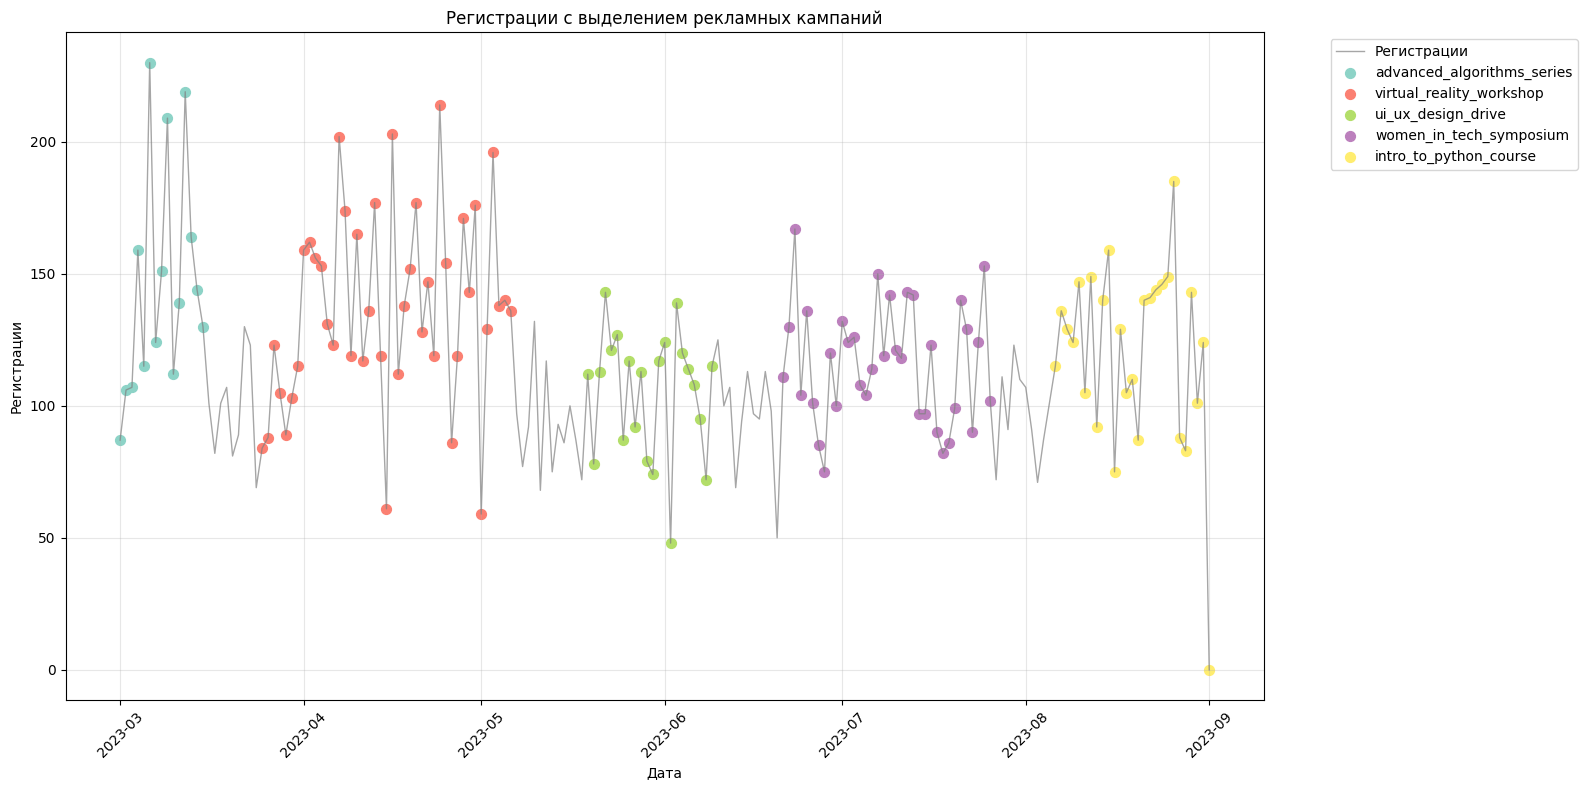

In [ ]:
# 8-9. Визиты и регистрации с выделением кампаний
campaigns = df_final[df_final['utm_campaign'] != 'none']['utm_campaign'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(campaigns)))
color_map = dict(zip(campaigns, colors))

for metric, title in [('visits', 'Визиты'), ('registrations', 'Регистрации')]:
    plt.figure(figsize=(16, 8))
    plt.plot(df_final['date_group'], df_final[metric], color='gray', alpha=0.7, linewidth=1, label=title)
    for campaign in campaigns:
        campaign_data = df_final[df_final['utm_campaign'] == campaign]
        if len(campaign_data) > 0:
            plt.scatter(campaign_data['date_group'], campaign_data[metric], color=color_map[campaign], s=50, label=campaign)
    plt.title(f'{title} с выделением рекламных кампаний'); plt.xlabel('Дата'); plt.ylabel(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left'); plt.grid(True, alpha=0.3); plt.xticks(rotation=45)
    plt.tight_layout(); plt.savefig(f'./charts/{metric}_with_campaigns.png', dpi=300, bbox_inches='tight'); plt.show()

# 7. Статистика

In [ ]:
print("="*50)
print("ИТОГОВАЯ СТАТИСТИКА:")
print("="*50)
print(f"Период анализа: {DATE_BEGIN} - {DATE_END}")
print(f"Всего визитов (без ботов): {df_conversion['visits'].sum()}")
print(f"Всего регистраций: {df_conversion['registrations'].sum()}")
print(f"Общая конверсия: {(df_conversion['registrations'].sum() / df_conversion['visits'].sum() * 100):.2f}%")
print(f"Дней с рекламой: {len(df_final[df_final['cost'] > 0])}")
print(f"Общие затраты на рекламу: {df_final['cost'].sum():.2f} у.е.")

print("\nКонверсия по платформам:")
for platform in platforms:
    platform_data = df_conversion[df_conversion['platform'] == platform]
    visits = platform_data['visits'].sum()
    regs = platform_data['registrations'].sum()
    conv = (regs / visits * 100) if visits > 0 else 0
    print(f"  {platform}: {conv:.2f}% ({regs}/{visits})")

ИТОГОВАЯ СТАТИСТИКА:
Период анализа: 2023-03-01 - 2023-09-01
Всего визитов (без ботов): 138703
Всего регистраций: 21836
Общая конверсия: 15.74%
Дней с рекламой: 143
Общие затраты на рекламу: 27754.00 у.е.

Конверсия по платформам:
  android: 75.74% (10582/13972)
  ios: 75.41% (4377/5804)
  web: 5.78% (6877/118927)
